# NLP Group Project

## Slogan Generator with GPT-2

### Install the required libraries

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

### Mount Google Drive
Mounting Google Drive is required to access the model's state dictionary to avoid retraining.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the Tokenizer and Model.

Create the `GPT2Tokenizer` and `GPT2LMHeadModel` objects.

In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

MODEL_NAME = 'distilgpt2' #'distilgpt2' 'gpt2-medium'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)

### Declare special tokens

First we create a token for padding. The padding token is used to make all sequences in a batch the same length. The padding token is also used when we want to generate a sequence of a certain length.

Next we create a token for separating the prompt from the output.

Finally we create a token for the company, so that the model can recognize the name of the company in the prompt and reproduce slogans with the name of the company in it.

In [4]:
SPECIAL_TOKENS_DICT = {
    'pad_token': '<pad>',
    'additional_special_tokens': ['<prompt>', '<output>', '<company>'],
}

tokenizer.add_special_tokens(SPECIAL_TOKENS_DICT)
model.resize_token_embeddings(len(tokenizer))

print(tokenizer.special_tokens_map)

{'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<pad>', 'additional_special_tokens': ['<prompt>', '<output>', '<company>']}


### Create a SloganDataset class as a child class of Torch's Dataset.

1. The `SloganDataset` class inherits from the `torch.utils.data.Dataset` class and takes `df`, `tokenizer`, and `seq_length` as input parameters. The `seq_length` parameter is set by default to 64.

2. Inside the constructor `__init__()`, the additional special tokens and padding token are extracted from the tokenizer and assigned to variables: `prompt_tkn`, `output_tkn`, `pad_tkn`, and `eos_tkn`.

3. For each row in the DataFrame, the prompt and output are tokenized using the tokenizer. The prompt tokens are prepended with the `prompt_tkn`, and the output tokens are prepended with `output_tkn` and appended with `eos_tkn`.

4. The prompt tokens, output tokens, and padding tokens are concatenated to form the `tokens` list, ensuring a fixed length of `seq_length` by padding with `pad_tkn` if necessary.

5. The `segments` list is created to annotate each token with its corresponding segment. The prompt tokens are assigned the `prompt_tkn`, and the output tokens are assigned the `output_tkn`.

6. The `labels` list is created to represent the labels for each token. The prompt tokens, padding tokens, and the `<output>` token are ignored by setting their labels to -100, while the rest of the output tokens retain their respective values.

7. The preprocessed example, consisting of `tokens`, `segments`, and `labels`, is appended to the `self.examples` list, which holds all the preprocessed examples.

8. The `__len__()` method is implemented to return the length of the dataset, which is the number of examples stored in `self.examples`.

9. The `__getitem__()` method is implemented to retrieve an item from the dataset given its index `item`. It returns a tensor representation of the example stored in `self.examples`.

In [ ]:
import torch
from torch.utils.data import Dataset


class SloganDataset(Dataset):
  def __init__(self, df, tokenizer, seq_length=64):


    prompt_tkn = tokenizer.additional_special_tokens_ids[0]
    output_tkn = tokenizer.additional_special_tokens_ids[1]
    pad_tkn = tokenizer.pad_token_id
    eos_tkn = tokenizer.eos_token_id

    self.examples = []
    self.df = df

    for _, row in self.df.iterrows():
        prompt = [prompt_tkn] + tokenizer.encode(row['prompt'], max_length=seq_length//2-1)
        output = [output_tkn] + tokenizer.encode(row['output'], max_length=seq_length//2-2) + [eos_tkn]
        
        tokens = prompt + output + [pad_tkn] * ( seq_length - len(prompt) - len(output) )

        segments = [prompt_tkn] * len(prompt) + [output_tkn] * ( seq_length - len(prompt) )

        labels = [-100] * (len(prompt)+1) + output[1:] + [-100] * ( seq_length - len(prompt) - len(output) )

        self.examples.append((tokens, segments, labels))

  def __len__(self):
    return len(self.examples)

  def __getitem__(self, item):
    return torch.tensor(self.examples[item])

After importing the required libraries, we read the CSV file containing the slogans and create a `DataFrame` object. The `DataFrame` object is then split into training, validation and test sets after being shuffled.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('all_slogans.csv', delimiter=";")
df = df.sample(frac=1).reset_index(drop=True)

train, dev, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

train_dataset = SloganDataset(train, tokenizer)
dev_dataset = SloganDataset(dev, tokenizer)
test_dataset = SloganDataset(test, tokenizer)

print(next(iter(train_dataset)).size())
print(next(iter(dev_dataset)).size())
print(next(iter(test_dataset)).size())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


torch.Size([3, 64])
torch.Size([3, 64])
torch.Size([3, 64])


### DataLoaders

DataLoaders elements are used to iterate over the dataset. The `DataLoader` class takes a dataset as input and returns batches of data. The `DataLoader` class also takes the `batch_size` parameter, which is set to 64 by default.

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32)
dev_loader = DataLoader(dev_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

### Training

The next code defines a function called `fit` that trains the model using the provided optimizer and data loaders for training and validation.

1. The `fit` function takes several input parameters: `model` (the model to be trained), `optimizer` (the optimizer for updating model parameters), `train_dl` (the data loader for the training set), `val_dl` (the data loader for the validation set), `epochs` (the number of training epochs), and `device` (the device to be used for training, with a default value of `torch.device('cpu')`).

2. The function starts a loop over the specified number of epochs. Inside each epoch, it prints the epoch number.

3. The model is set to training mode using `model.train()`.

4. Two lists, `losses` and `nums`, are initialized to keep track of the batch losses and batch sizes over one epoch.

5. The function iterates over the batches in the training data loader using `tqdm` for progress tracking.

6. Each batch is moved to the specified device using `inputs = xb.to(device)`.

7. The model is called with the input token IDs, segment IDs, and labels using `outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])`.

8. The loss is computed and added to the `losses` list, and the batch size is added to the `nums` list.

9. Backpropagation is performed by calling `loss.backward()`.

10. The optimizer takes a step to update the model parameters using `optimizer.step()`, and the model gradients are reset to zero using `model.zero_grad()`.

11. After the epoch is finished, the average training cost is computed by multiplying the losses with the respective batch sizes, summing them, and dividing by the total number of samples in the epoch.

12. The model is switched to evaluation mode using `model.eval()`.

13. Validation is performed on the validation data loader using a similar process as training, but without backpropagation. The losses and batch sizes are stored in `losses` and `nums`, respectively.

14. The average validation cost is computed in the same way as the training cost.

15. Finally, the epoch number, training cost, and validation cost are printed.

In [ ]:
import numpy as np
from tqdm import tqdm

def fit(model, optimizer, train_dl, val_dl, epochs=1, device=torch.device('cpu')):
  for i in range(epochs):
    print('\n--- Starting epoch #{} ---'.format(i+1))
    model.train()
    losses = []
    nums = []
    for xb in tqdm(train_dl, desc="Training"):
      inputs = xb.to(device)
      outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])
      
      loss = outputs[0]
      losses.append(loss.item())
      nums.append(len(xb))
      loss.backward()
      optimizer.step()
      model.zero_grad()

    train_cost = np.sum(np.multiply(losses, nums)) / sum(nums)

    model.eval()
    with torch.no_grad():
      losses = []
      nums = []
      for xb in tqdm(val_dl, desc="Validation"):
        inputs = xb.to(device)
        outputs = model(inputs[:,0,:], token_type_ids=inputs[:,1,:], labels=inputs[:,2,:])
        losses.append(outputs[0].item())
        nums.append(len(xb))

    val_cost = np.sum(np.multiply(losses, nums)) / sum(nums)

    print('\n--- Epoch #{} finished --- Training cost: {} / Validation cost: {}'.format(i+1, round(train_cost, 3), round(val_cost, 3)))

This code block fine-tunes a GPT2 model for `n` epochs using the AdamW optimizer. Here's an overview of the code:

1. It creates a `torch.device` object named `device` with the device type set to `'cuda'`, indicating that the GPU will be used for training.

2. The `model` is moved to the GPU by calling `model.to(device)`, which ensures that the model's parameters and computations will be performed on the GPU.

3. An instance of the AdamW optimizer is created by passing `model.parameters()` as the parameter. This optimizer will update the parameters of the `model` during training.

4. The `fit` function is called with the following arguments: `model` (the GPT2 model), `optimizer` (the AdamW optimizer), `train_loader` (the data loader for the training set), `dev_loader` (the data loader for the validation set), `epochs=2` (indicating two training epochs), and `device=device` (specifying the device to be used for training).

In [ ]:
from transformers import AdamW

device = torch.device('cuda')
model.to(device)

optimizer = AdamW(model.parameters(), no_deprecation_warning=True)
fit(model, optimizer, train_loader, dev_loader, epochs=5, device=device)


--- Starting epoch #1 ---


Validation: 100%|██████████| 19/19 [00:04<00:00,  4.62it/s]



--- Epoch #1 finished --- Training cost: 3.738 / Validation cost: 2.767

--- Starting epoch #2 ---


Validation: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s]



--- Epoch #2 finished --- Training cost: 2.285 / Validation cost: 2.862

--- Starting epoch #3 ---


Validation: 100%|██████████| 19/19 [00:04<00:00,  4.67it/s]



--- Epoch #3 finished --- Training cost: 1.708 / Validation cost: 3.141

--- Starting epoch #4 ---


Validation: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s]



--- Epoch #4 finished --- Training cost: 1.269 / Validation cost: 3.459

--- Starting epoch #5 ---


Validation: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s]


--- Epoch #5 finished --- Training cost: 0.979 / Validation cost: 3.795


Save the model after the training.

In [ ]:
model_path = '/content/model.pt'
torch.save(model.state_dict(), model_path)

Save all the datasets.

In [ ]:
train.to_csv('train.csv', sep=';')
dev.to_csv('dev.csv', sep=';')
test.to_csv('test.csv', sep=';')

### Load the model and the datasets after training

Load the saved model to avoid retraining.

In [5]:
import torch
model_path = '/content/drive/MyDrive/model.pt'
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict, model_path)
device = torch.device('cuda')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

Load the datasets.

In [6]:
import pandas as pd
train = pd.read_csv('train.csv', sep=';')
dev = pd.read_csv('dev.csv', sep=';')
test = pd.read_csv('test.csv', sep=';')

### Generate Slogans

The `top_k_top_p_filtering` function defined below implements a filtering mechanism for probability distributions of logits using top-k and/or nucleus (top-p) filtering techniques. Let's break down the code and explain the idea behind this filtering:

1. `top_k = min(top_k, logits.size(-1))`: This line ensures that `top_k` is not greater than the size of the logits distribution, which represents the vocabulary size. It performs a safety check to prevent errors.

2. Top-k Filtering:
   - `if top_k > 0`: This condition checks if top-k filtering is enabled.
   - `indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]`: This line finds the `top_k`-th largest value in the logits and creates a Boolean mask indicating the tokens with probabilities less than this threshold. Tokens with probabilities below the threshold will be removed.
   - `logits[indices_to_remove] = filter_value`: This sets the logits of the filtered tokens to `filter_value`, which is typically negative infinity. This effectively removes the tokens with lower probabilities from the distribution.

3. Nucleus (Top-p) Filtering:
   - `if top_p > 0.0`: This condition checks if nucleus filtering is enabled.
   - `sorted_logits, sorted_indices = torch.sort(logits, descending=True)`: This line sorts the logits in descending order and returns the sorted logits and their corresponding indices.
   - `cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)`: Here, the softmax is applied to the sorted logits, and the cumulative probabilities are computed along the last dimension.
   - `sorted_indices_to_remove = cumulative_probs > top_p`: This line creates a Boolean mask indicating the tokens with cumulative probabilities above the `top_p` threshold.
   - `sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()`: This line shifts the indices to the right, effectively removing the first token above the threshold but keeping the rest.
   - `sorted_indices_to_remove[..., 0] = 0`: This sets the first token above the threshold to 0, ensuring it is not removed.
   - `indices_to_remove = sorted_indices_to_remove.scatter(dim=1, index=sorted_indices, src=sorted_indices_to_remove)`: This scatters the sorted indices back to their original positions, allowing the filtering of the original logits distribution.
   - `logits[indices_to_remove] = filter_value`: Similar to top-k filtering, this line sets the logits of the filtered tokens to `filter_value`, effectively removing them from the distribution.

Finally, the function returns the filtered logits distribution. The filtering mechanism helps control the diversity and randomness of the generated text by constraining the distribution based on the top-k tokens and/or cumulative probability threshold (top-p).

In [ ]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    top_k = min(top_k, logits.size(-1))
    if top_k > 0:
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices_to_remove.scatter(dim=1, index=sorted_indices, src=sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

The `sample_sequence` function generates slogans using GPT-2 by sampling tokens sequentially. Let's break down the code and explain its functionality:

1. `prompt = torch.tensor(prompt, dtype=torch.long, device=device)`: This line converts the `prompt` into a PyTorch tensor of type `torch.long` and moves it to the GPU.

2. `prompt = prompt.unsqueeze(0).repeat(num_samples, 1)`: The `prompt` tensor is unsqueezed to add a batch dimension of size 1, and then repeated `num_samples` times to create multiple independent sequences for generating multiple slogans simultaneously.

3. `generated = prompt`: The `generated` tensor is initialized with the prompt, which serves as the starting point for generating the slogans.

4. The generation process begins with a loop that iterates `length` times to generate the desired number of tokens for each slogan:

   - `inputs = {'input_ids': generated}`: The `generated` tensor is used as the input to the model. It contains the token IDs of the previously generated tokens.
   
   - `if segments_tokens != None: ...`: If `segments_tokens` is provided, it represents the segment or context information for the input tokens. It is used to create the 'token_type_ids' tensor that specifies the segment information for each token in `generated`.

   - `outputs = model(**inputs)`: The model is called with the `inputs` dictionary to obtain the model outputs. The specific details may vary depending on the model architecture.

   - `next_token_logits = outputs[0][:, -1, :] / (temperature if temperature > 0 else 1.)`: The logits for the next token in the sequence are extracted from the model outputs. The logits are divided by the temperature value to control the randomness of the sampling. If `temperature` is 0, greedy sampling is performed by choosing the token with the highest probability.

   - `for i in range(num_samples): ...`: For each individual slogan sequence, a repetition penalty is applied to discourage repeated tokens. The logits for each token that already exists in the generated sequence are divided by the `repetition_penalty` value.

   - `filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)`: The `top_k_top_p_filtering` function is applied to the logits to filter the distribution based on the top-k and/or nucleus (top-p) filtering techniques. This helps control the diversity and randomness of the generated slogans.

   - `if temperature == 0: ...`: If `temperature` is 0, greedy sampling is performed by selecting the token with the highest probability (argmax) from the filtered logits. The selected token is unsqueezed and added to the `generated` tensor.

   - `else: ...`: For non-zero `temperature` values, multinomial sampling is performed using the filtered logits and the `num_samples` parameter. The sampled token is unsqueezed and added to the `generated` tensor.

5. Finally, the function returns the `generated` tensor, which contains the generated slogans.

In [ ]:
import torch.nn.functional as F
from tqdm import trange

def sample_sequence(model, length, prompt, segments_tokens=None, num_samples=1, temperature=1, top_k=0, top_p=0.0, repetition_penalty=1.0,
                    device='cpu'):
    prompt = torch.tensor(prompt, dtype=torch.long, device=device)
    prompt = prompt.unsqueeze(0).repeat(num_samples, 1)
    generated = prompt

    with torch.no_grad():
        # for _ in trange(length, leave=True):
        for _ in range(length):
            inputs = {'input_ids': generated}
            if segments_tokens != None:
              inputs['token_type_ids'] = torch.tensor(segments_tokens[:generated.shape[1]]).unsqueeze(0).repeat(num_samples, 1)

            outputs = model(**inputs)
            next_token_logits = outputs[0][:, -1, :] / (temperature if temperature > 0 else 1.)

            for i in range(num_samples):
                for _ in set(generated[i].tolist()):
                    next_token_logits[i, _] /= repetition_penalty
                
            filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
            if temperature == 0:
                next_token = torch.argmax(filtered_logits, dim=-1).unsqueeze(-1)
            else:
                next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token), dim=1)
            
    # trange.close()

    return generated

Slogan generation from a single prompt to quickly evaluate the performance of the model.

In [ ]:
prompt = "Coca-Cola, Drinking"

prompt_tkn = tokenizer.additional_special_tokens_ids[0]
output_tkn = tokenizer.additional_special_tokens_ids[1]

input_ids = [prompt_tkn] + tokenizer.encode(prompt)

segments = [output_tkn] * 64
segments[:len(input_ids)] = [prompt_tkn] * len(input_ids)

input_ids += [output_tkn]

model.to(torch.device('cpu'))

generated = sample_sequence(model, length=20, prompt=input_ids, segments_tokens=segments, num_samples=20)

print('\n--- Generated Slogans ---\n')

for g in generated:
  slogan = tokenizer.decode(g.squeeze().tolist())
  slogan = slogan.split('<|endoftext|>')[0].split('<output>')[1]
  print(slogan)

100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


--- Generated Slogans ---

 Coca-Cola, Breathing life.
 Coca-Cola, Taste it everything.
 Coca-Cola, Taste the possibilities.
 Coca-Cola, Taste the possibilities.
 Coca-Cola, Just chill.
 Coca-Cola, Taste the possibilities.
 Coca-Cola, Just try and Smirk.
 Coca-Cola, Taste the possibilities.
 Coca-Cola, Taste the possibilities.
 Coca-Cola, Taste it together.
 Coca-Cola, Welcome to the World Cup Cup.
 Coca-Cola, Have fun in it.
 Coca-Cola, What's for breakfast like today?
 Coca-Cola, Taste the possibilities.
 Coca-Cola, Try theCola. Try the World.
 Coca-Cola, Taste the mystery.
 Coca-Cola, Have you heard the Pepsi-Cola test of it?
 Coca-Cola, Taste it all.
 Coca-Cola, Brew the Pepsi, Think of it as a Coke.
 Coca-Cola, Smell it. Don't believe it.


All slogans seem pretty good. However there are several repetitions of the same slogan.\
This is not a bad thing, but it is not ideal.

Here in the following block we create a function that generates slogans from a list of prompts.\
This function will be used to generate the slogans for the test set.

In [ ]:
from tqdm import trange

def generate_slogans_for_column(prompt, model, tokenizer):
    prompt_tkn = tokenizer.additional_special_tokens_ids[0]
    output_tkn = tokenizer.additional_special_tokens_ids[1]

    input_ids = [prompt_tkn] + tokenizer.encode(prompt)
    segments = [output_tkn] * 64
    segments[:len(input_ids)] = [prompt_tkn] * len(input_ids)
    input_ids += [output_tkn]

    model.to(torch.device('cpu'))

    generated = sample_sequence(model, length=20, prompt=input_ids, segments_tokens=segments, num_samples=1)

    # slogans = []
    # for g in generated:
    slogan = tokenizer.decode(generated.squeeze().tolist())
    slogan = slogan.split('<|endoftext|>')[0].split('<output>')[1]
    return slogan[1:]

def generate_slogans_for_dataset(data_column, model, tokenizer):
    generated_slogans = []
    with trange(len(data_column), leave=True) as pbar:
        for prompt in data_column:
            slogans = generate_slogans_for_column(prompt, model, tokenizer)
            generated_slogans.append(slogans)
            pbar.update(1)
    return generated_slogans

In [ ]:
test['output_generated'] = generate_slogans_for_dataset(test['prompt'], model, tokenizer)

100%|██████████| 1162/1162 [37:50<00:00,  1.95s/it]


In [ ]:
test

,Unnamed: 0,company,category,slogan,language,slogan_masked,prompt,output,output_generated
0,1435,The National Lottery,Sports,It could be you,en,It could be you,"The National Lottery, Sports","The National Lottery, It could be you","The National Lottery, Play the National Lotter..."
1,529,Minute Maid,Drinking,For moms who know.,en,For moms who know.,"Minute Maid, Drinking","Minute Maid, For moms who know.","Minute Maid, Prettier than the Maid."
2,8898,P&O Ferries,Tours,You deserve a holiday.,en,You deserve a holiday.,"P&O Ferries, Tours","P&O Ferries, You deserve a holiday.","P&O Ferries, Where you come first."
3,1497,Holiday Inn,Tours,We put a smile back on your face.,en,We put a smile back on your face.,"Holiday Inn, Tours","Holiday Inn, We put a smile back on your face.","Holiday Inn, It over the world'sHoliday Innkee..."
4,7097,Best Buy,Business,Turn on the fun.,en,Turn on the fun.,"Best Buy, Business","Best Buy, Turn on the fun.","Best Buy, Expert Service. Streetwise Price."
...,...,...,...,...,...,...,...,...,...
1157,2594,Disney Junior,Business,Welcome to Disney Junior!,en,Welcome to <company>!,"Disney Junior, Business","Disney Junior, Welcome to Disney Junior!","Disney Junior, Where the Magic Begins!"
1158,8192,Intel,Technology,The Computer Inside.,en,The Computer Inside.,"Intel, Technology","Intel, The Computer Inside.","Intel, Sponsors of tomorrow."
1159,4695,Emirates,Airlines,"Fly us once, fly us always",en,"Fly us once, fly us always","Emirates, Airlines","Emirates, Fly us once, fly us always","Emirates, Fly the airline of the year 2005."
1160,8992,Woodford Reserve,Drinking,Handcrafted Kentucky bourbon.,en,Handcrafted Kentucky bourbon.,"Woodford Reserve, Drinking","Woodford Reserve, Handcrafted Kentucky bourbon.","Woodford Reserve, Woodford Reserve Reclass <co..."


Export the test dataset with generations to a csv file.

In [ ]:
test.to_csv('test_generated.csv', sep=';')

Load the test dataset with generations from the csv file.

In [7]:
test_gen = pd.read_csv('test_generated.csv', sep=';')

We create a copy of the test dataset with generations and we remove the original slogans.\
This is done to concatenate the generated slogans with the original ones.

Before recombining the generated slogans with the original ones, we create a column `generated` that tells us if the slogan is generated or not.

In [8]:
test_copy = test_gen.drop('output', axis=1).rename(columns={'output_generated':'output'})

test_copy['generated'] = 1
train['generated'] = 0
dev['generated'] = 0

df_class = pd.concat([train, dev, test_copy])

In [9]:
df_class.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df_class.reset_index(drop=True)

,company,category,slogan,language,slogan_masked,prompt,output,generated
0,Massachusetts,Tours,Massachusetts: where God is God,en,<company>: where God is God,"Massachusetts, Tours","Massachusetts, Massachusetts: where God is God",0
1,Café Coffee Day,Drinking,We’re Brewing A Marathon Of Celebrations This ...,en,We’re Brewing A Marathon Of Celebrations This ...,"Café Coffee Day, Drinking","Café Coffee Day, We’re Brewing A Marathon Of C...",0
2,Colorado,Tours,Rocky Mountain Empire,en,Rocky Mountain Empire,"Colorado, Tours","Colorado, Rocky Mountain Empire",0
3,Lipton,Drinking,Start something good.,en,Start something good.,"Lipton, Drinking","Lipton, Start something good.",0
4,Boost,Food,Boost Guarana: One Step Ahead.,en,<company> Guarana: One Step Ahead.,"Boost, Food","Boost, Boost Guarana: One Step Ahead.",0
...,...,...,...,...,...,...,...,...
11613,Disney Junior,Business,Welcome to Disney Junior!,en,Welcome to <company>!,"Disney Junior, Business","Disney Junior, Where the Magic Begins!",1
11614,Intel,Technology,The Computer Inside.,en,The Computer Inside.,"Intel, Technology","Intel, Sponsors of tomorrow.",1
11615,Emirates,Airlines,"Fly us once, fly us always",en,"Fly us once, fly us always","Emirates, Airlines","Emirates, Fly the airline of the year 2005.",1
11616,Woodford Reserve,Drinking,Handcrafted Kentucky bourbon.,en,Handcrafted Kentucky bourbon.,"Woodford Reserve, Drinking","Woodford Reserve, Woodford Reserve Reclass <co...",1


Of course now all the generated slogans are at the end of the dataset, so the dataset will be shuffled again for the next steps.

## BERT Classifier

The slogan generation process appears to be functioning properly. However, in order to determine the suitability of the generated slogans for real-world use, it is important to evaluate them. To accomplish this, we employ the **BERT** model for the classification of the slogans into generated or non-generated categories.

After having recombined the previous datasets in a new one, we reshuffle it. Then we split it again into train, dev, test.

In [10]:
import numpy as np

train_class, dev_class, test_class = np.split(df_class.sample(frac=1), [int(.8*len(df_class)), int(.9*len(df_class))])

In [11]:
train_class.generated.value_counts()

0    8372
1     922
Name: generated, dtype: int64

In [12]:
dev_class.generated.value_counts()

0    1052
1     110
Name: generated, dtype: int64

In [13]:
test_class.generated.value_counts()

0    1032
1     130
Name: generated, dtype: int64

### Tokenization

To pass the dataset to the BERT model, we need to convert the slogans into tokens.\
We use the `BertTokenizer` class to tokenize the slogans.

We initialize the `BertTokenizer` class with the `bert-base-uncased` model and we initialize the `BertForSequenceClassification` class with the `bert-base-uncased` model and the number of classes.

In [14]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer_class = BertTokenizer.from_pretrained('bert-base-uncased')
model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

We tokenize the slogans for the train, dev and test sets.

In [15]:
train_slogan_encodings = tokenizer_class(train_class['output'].tolist(), truncation=True, padding=True)
dev_slogan_encodings = tokenizer_class(dev_class['output'].tolist(), truncation=True, padding=True)
test_slogan_encodings = tokenizer_class(test_class['output'].tolist(), truncation=True, padding=True)

### Create Datasets

As we did fror the GPT-2 model, we create a custom dataset for the BERT model.

We create the dataloaders for the train, dev and test sets.

In [16]:
import torch
from torch.utils.data import DataLoader

class ClassDataset(torch.utils.data.Dataset):

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_class = ClassDataset(train_slogan_encodings, train_class['generated'].tolist())
dev_dataset_class = ClassDataset(dev_slogan_encodings, dev_class['generated'].tolist())
test_dataset_class = ClassDataset(test_slogan_encodings, test_class['generated'].tolist())

train_loader_class = DataLoader(train_dataset_class, batch_size=16, shuffle=True)
dev_loader_class = DataLoader(dev_dataset_class, batch_size=16, shuffle=True)
test_loader_class = DataLoader(test_dataset_class, batch_size=16, shuffle=True)

### Training the BERT model

Before running the training loop we check the availability of a CUDA-enabled GPU and set the device accordingly, thus the model is moved to the chosen device. The we initialize the AdamW optimizer, passing the model parameters and setting the learning rate.
Now we can enter the training loop, iterating over a specified number of epochs, which this time is 3.

In the loop we perform the following steps:
1. Set the model to training mode.
2. Iterate over the batches in the training data loader.
3. Clear the gradients of the optimizer.
4. Move the input data, attention mask, and labels to the chosen device.
5. Perform a forward pass through the model, obtaining the outputs.
6. Calculate the loss based on the model outputs.
7. Perform backpropagation to compute the gradients of the model parameters.
8. Update the model parameters using the optimizer.

In [18]:
from transformers import AdamW
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_class.to(device)

optim = AdamW(model_class.parameters(), lr=5e-5)

for epoch in tqdm(range(5)):
    model_class.train()
    for batch in train_loader_class:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_class(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

100%|██████████| 5/5 [05:41<00:00, 68.38s/it]


Save the classifier model to a file so that it can be loaded later and avoid the need to retrain it.

In [19]:
model_path = '/content/model_class.pt'
torch.save(model_class.state_dict(), model_path)

Load the classifier model from a file, then move it to the chosen device.

In [ ]:
import torch
model_path = '/content/drive/MyDrive/model_class.pt'
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model_class.load_state_dict(state_dict, model_path)
device = torch.device('cuda')
model_class.to(device)

### Evaluate the model

Now it is time to evaluate the performance of the model on the test set.

We set the model to evaluation mode, then we initialize empty lists to store the predicted labels and true labels.
Then we enter a loop that iterates over the batches in the validation data loader and performs the following steps:
1. Iterate over the batches in the validation data loader.
2. Move the input data and attention mask to the chosen device.
3. Perform a forward pass through the model without computing gradients.
4. Extract the logits from the model outputs.
5. Append the predicted labels to the `preds_class` list by selecting the class index with the highest probability (argmax) along the last dimension of the logits.
6. Append the true labels to the `labels_class` list.

In [21]:
model_class.eval()
preds_class = []
labels_class = []
for batch in dev_loader_class:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model_class(input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    preds_class.extend(logits.argmax(dim=-1).tolist())
    labels_class.extend(batch['labels'].tolist())

We calculate the accuracy of the model on the validation set.

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy_class = accuracy_score(labels_class, preds_class)
f1_class = precision_recall_fscore_support(labels_class, preds_class, average='weighted')

print('Accuracy:', accuracy_class)
print('F1 Score:', f1_class)

Accuracy: 0.891566265060241
F1 Score: (0.8618054953627459, 0.891566265060241, 0.8727381800770551, None)


Even though the score seems pretty high, we must keep in mind that almost 90% of the slogans in the test set are original, so we expect the model at least to spot them.

However the model is not able to predict all the correct labels, which means that our slogan builder performed well.

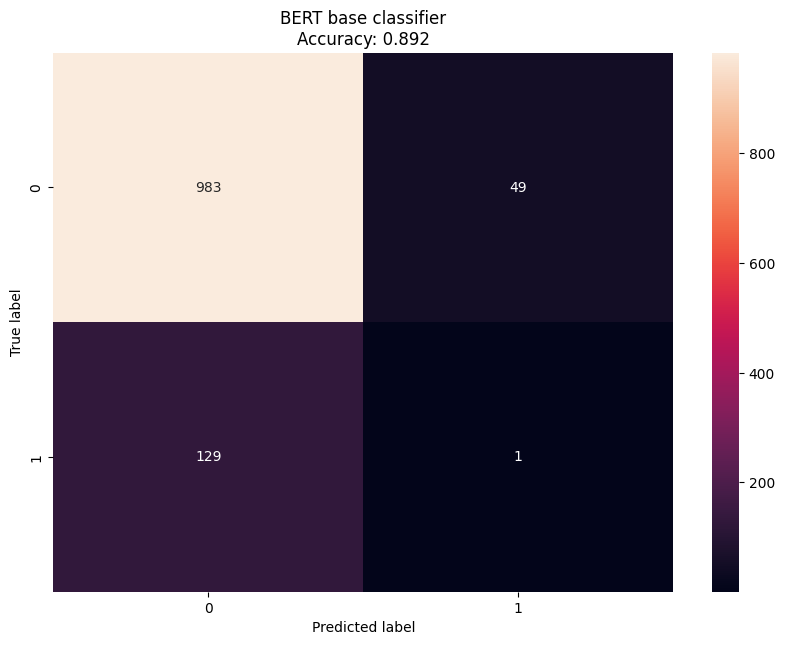

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_class['generated'], preds_class, labels=train_class['generated'].unique())

cm_df = pd.DataFrame(cm, index = train_class['generated'].unique(),
                        columns = train_class['generated'].unique())

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('BERT base classifier\nAccuracy: {0:.3f}'.format(accuracy_class))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

By plotting the confusion matrix we can see that our classifier misclassified almost all generated slogans. In fact, we can see that 129 out 130 generated slogans have been labeled as original while actually they were not (False Positive).

Note that the model also predicted 49 False Negative slogans, which means that somehow the model spotted something unregular in the original slogans, which might have been a confounder for generated slogans.

Append the results of the classifier to the test set.

In [24]:
test_class['class'] = preds_class

### Show some examples of the classification.

When printing the only TN, we see that it looks pretty credible actually.

In [25]:
test_class[(test_class['class']==1)&(test_class['generated']==1)].output.tolist()

['Folgers, Folgers in Folgers.']

Let's give a look at the False Positives.

In [26]:
test_class[(test_class['class']==1)&(test_class['generated']==0)].output.tolist()

['Subway, If you are eating at Subway, then you areeating fresh.',
 'Play-Doh, Fun to play with, not to eat',
 "Weston's Cider, Cider inspired by tradition.",
 'Knipex, The think tank.',
 'Travelers, Get Rewarded for Doing the right thing.',
 'Loblaws, At Loblaws, more than the price is right.',
 'Provogue, Passion is the genesis of genius',
 "Harry Ramsden's, World famous fish & chips.",
 'H&M, Reality is better than fantasy',
 "Chupa Chups, It's round and long-lasting. \xa0",
 "Cravendale, It's not just any milk, it's filtered to make it purer.",
 'Cadbury Creme Egg, Goo Dares Wins',
 'British Heart Foundation, Seven out of ten people over 45 have high cholesterol',
 'Numerica Credit Union, We might just be what you need.',
 'American Red Cross, Roll up your sleeves',
 "iphone, There's an app for that. That's the iPhone. Solving life's dilemma one app at a time",
 'Industrial Credit Union, In Your Corner',
 'Life, He likes it! Hey Mikey!',
 'Saint-Gobain, From sand to screen',
 'Finn

Let's look at some of the generated slogans

In [27]:
test_class[test_class['generated']==1].output.tolist()[:20]

['Primula, Perfect with primer.',
 'Progressive Broadcasting Corporation, Wasted, over 60 ads in an hour',
 'Pinnacle Bank, Wherever you succeed,innacle Bank.',
 'Finnair, More thinking of your business world',
 'National Express, A Express for the card',
 'Nescafe, 95% of all body and sugar drop from caffein.',
 "The Macallan distillery, The only taste that's stood the test of time",
 'Wesfarmers, Definitely at the corner.',
 'Benefit Cosmetics, TH LAST, TOUGH TOUGH TOUGH TOUGH TOUGH TOUGH',
 'H&M, Be you this one',
 'Dannon Yogurt, One Planet Needs One One Mother.',
 'Ghirardelli Chocolate, Drink the social me away, Drink the Churn & Charge',
 'BFGoodrich, BFGoodrich. Beyond BFGoodrich.',
 'Labatt Brewing Company, Stop your mind before your taste.',
 'Telecom Egypt, Digital World-Vision',
 "Nebraska, It's in the Bos Know Right place!",
 'Nebraska, Myth Becomes Reality in Colorado',
 'Hershey bar, Hello You. Hello You. Hello Your Beer. Hello Your Hooray',
 "Crunchie, Get back to where

Save the datasets

In [28]:
train_class.to_csv('train_class.csv', sep=";")
dev_class.to_csv('dev_class.csv', sep=";")
test_class.to_csv('test_class.csv', sep=";")

In [2]:
train_class = pd.read_csv('train_class.csv', sep=";")
dev_class = pd.read_csv('dev_class.csv', sep=";")
test_class = pd.read_csv('test_class.csv', sep=";")

## XGBoost Classifier

Repeat the classification process with a different model.

At firts we create sentence embeddings for the slogans, using the `SentenceTransformer` class with a pretrained model, the `paraphrase-distilroberta-base-v1` model.

In [ ]:
# embeddings
from sentence_transformers import SentenceTransformer

model_embed = SentenceTransformer('paraphrase-distilroberta-base-v1')

train_embeddings = model_embed.encode(train_class['output'].tolist())
dev_embeddings = model_embed.encode(dev_class['output'].tolist())
test_embeddings = model_embed.encode(test_class['output'].tolist())

Then we create a XGBClassifier model and we perform a random search to find the best hyperparameters.

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [0, 1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='accuracy', n_jobs=-1, cv=5, verbose=3)
random_search.fit(train_embeddings, train_class['generated'])
# random_search.best_estimator_

Best parameters below:

In [14]:
xgb.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9,
 'eval_metric': None,
 'gamma': 0.2,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 0,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Once we have the best parameters, we train the model on the train set and we make predictions on the test set.

In [15]:
xgb = XGBClassifier(**random_search.best_params_)
xgb.fit(train_embeddings, train_class['generated'])
preds_xgb = xgb.predict(test_embeddings)

Lastly, we evaluate the model on the test set, computing the accuracy, F1 score and the confusion matrix.

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy_xgb = accuracy_score(test_class['generated'], preds_xgb)
f1_xgb = precision_recall_fscore_support(test_class['generated'], preds_xgb, average='weighted')

print('Accuracy:', accuracy_xgb)
print('F1 Score:', f1_xgb)

Accuracy: 0.8881239242685026
F1 Score: (0.7887641048580849, 0.8881239242685026, 0.8355003553738329, None)


c:\Users\morre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


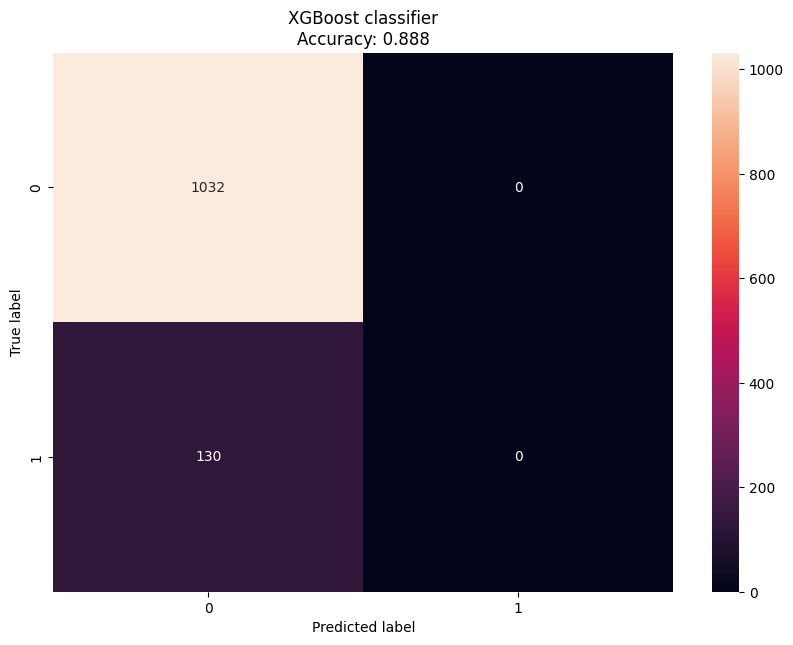

In [18]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_class['generated'], preds_xgb, labels=train_class['generated'].unique())

cm_df = pd.DataFrame(cm, index = train_class['generated'].unique(),
                        columns = train_class['generated'].unique())

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('XGBoost classifier\nAccuracy: {0:.3f}'.format(accuracy_xgb))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As we can see the model performs even worse than the BERT classifier model.